In [1]:
import pandas as pd
import numpy as np
import numba
import re
import cv2
import ast
import matplotlib.pyplot as plt

from numba import jit
from typing import List, Union, Tuple

from config import config

In [2]:
conf = config()

In [4]:
@jit(nopython=True)
def calculate_iou(gt, pr, form='coco') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

In [6]:
box1 = np.array([834.0, 222.0, 56.0, 36.0])
box2 = np.array([26.0, 144.0, 124.0, 117.0])

assert calculate_iou(box1, box2, form='coco') == 0.0

box1 = np.array([100, 100, 100, 100])
box2 = np.array([100, 100, 200, 100])

res = calculate_iou(box1, box2, form='coco')
assert  res > 0.5 and res < 0.50249

box1 = np.array([834.0, 222.0, 56.0, 36.0])
box2 = box1

assert calculate_iou(box1, box2, form='coco') == 1.0

In [8]:
train_df = pd.read_csv(conf.DATA_PATH+'/train.csv')
train_df.shape

(147793, 5)

In [9]:
box_data = np.stack(train_df['bbox'].apply(lambda x: ast.literal_eval(x)))
train_df[['x', 'y', 'w', 'h']] = pd.DataFrame(box_data).astype(np.float32)


In [12]:
@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1
    
    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx


@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)
        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [14]:
validation_image_precision = []
iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]

for images, targets in valid_data_loader:
    # ...
    #
    # outputs = model.forward(images)
    #
    # ...
    #
    # preds = ... # shape: (#predicted box, 4)
    # scores = ... # shape: (#predicted box, )
    # gt_boxes = ... # shape: (#ground-truth box, 4)

    preds_sorted_idx = np.argsort(scores)[::-1]
    preds_sorted = preds[preds_sorted_idx]

    for idx, image in enumerate(images):
        image_precision = calculate_image_precision(preds_sorted,
                                                    gt_boxes,
                                                    thresholds=iou_thresholds,
                                                    form='coco')

        validation_image_precisions.append(image_precision)

print("Validation IOU: {0:.4f}".format(np.mean(validation_image_precisions)))

NameError: name 'valid_data_loader' is not defined

In [15]:
sample_id = '1ef16dab1'

gt_boxes = train_df[train_df['image_id'] == sample_id][['x', 'y', 'w', 'h']].values
gt_boxes = gt_boxes.astype(np.int)

# Ground-truth boxes of our sample
gt_boxes

array([[954, 391,  70,  90],
       [660, 220,  95, 102],
       [ 64, 209,  76,  57],
       [896,  99, 102,  69],
       [747, 460,  72,  77],
       [885, 163, 103,  69],
       [514, 399,  90,  97],
       [702, 794,  97,  99],
       [721, 624,  98, 108],
       [826, 512,  82,  94],
       [883, 944,  79,  74],
       [247, 594, 123,  92],
       [673, 514,  95, 113],
       [829, 847, 102, 110],
       [ 94, 737,  92, 107],
       [588, 568,  75, 107],
       [158, 890, 103,  64],
       [744, 906,  75,  79],
       [826,  33,  72,  74],
       [601,  69,  67,  87]])

In [1]:
import numpy as np
from metric import calculate_image_precision
gt_boxes = np.array([[954, 391,  70,  90],
       [660, 220,  95, 102],
       [ 64, 209,  76,  57],
       [896,  99, 102,  69],
       [747, 460,  72,  77],
       [885, 163, 103,  69],
       [514, 399,  90,  97],
       [702, 794,  97,  99],
       [721, 624,  98, 108],
       [826, 512,  82,  94],
       [883, 944,  79,  74],
       [247, 594, 123,  92],
       [673, 514,  95, 113],
       [829, 847, 102, 110],
       [ 94, 737,  92, 107],
       [588, 568,  75, 107],
       [158, 890, 103,  64],
       [744, 906,  75,  79],
       [826,  33,  72,  74],
       [601,  69,  67,  87]])

In [2]:
# No GT - Predicted box match
pred_box = np.array([0, 0, 10, 10])
assert find_best_match(gt_boxes, pred_box, 0, threshold=0.5, form='coco') == -1

# First GT match
pred_box = np.array([954., 391., 70., 90.])
assert find_best_match(gt_boxes, pred_box, 0, threshold=0.5, form='coco') == 0

NameError: name 'find_best_match' is not defined

In [2]:
preds = np.array([[956, 409, 68, 85],
                  [883, 945, 85, 77],
                  [745, 468, 81, 87],
                  [658, 239, 103, 105],
                  [518, 419, 91, 100],
                  [711, 805, 92, 106],
                  [62, 213, 72, 64],
                  [884, 175, 109, 68],
                  [721, 626, 96, 104],
                  [878, 619, 121, 81],
                  [887, 107, 111, 71],
                  [827, 525, 88, 83],
                  [816, 868, 102, 86],
                  [166, 882, 78, 75],
                  [603, 563, 78, 97],
                  [744, 916, 68, 52],
                  [582, 86, 86, 72],
                  [79, 715, 91, 101],
                  [246, 586, 95, 80],
                  [181, 512, 93, 89],
                  [655, 527, 99, 90],
                  [568, 363, 61, 76],
                  [9, 717, 152, 110],
                  [576, 698, 75, 78],
                  [805, 974, 75, 50],
                  [10, 15, 78, 64],
                  [826, 40, 69, 74],
                  [32, 983, 106, 40]]
                )

scores = np.array([0.9932319, 0.99206185, 0.99145633, 0.9898089, 0.98906296, 0.9817738,
                   0.9799762, 0.97967803, 0.9771589, 0.97688967, 0.9562935, 0.9423076,
                   0.93556845, 0.9236257, 0.9102379, 0.88644403, 0.8808225, 0.85238415,
                   0.8472188, 0.8417798, 0.79908705, 0.7963756, 0.7437897, 0.6044758,
                   0.59249884, 0.5557045, 0.53130984, 0.5020239])

# Sort highest confidence -> lowest confidence
preds_sorted_idx = np.argsort(scores)[::-1]
preds_sorted = preds[preds_sorted_idx]

In [19]:
def show_result(sample_id, preds, gt_boxes):
    sample = cv2.imread(conf.DATA_PATH+'/train/'+sample_id+'.jpg', cv2.IMREAD_COLOR)
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for pred_box in preds:
        cv2.rectangle(
            sample,
            (pred_box[0], pred_box[1]),
            (pred_box[0] + pred_box[2], pred_box[1] + pred_box[3]),
            (220, 0, 0), 2
        )

    for gt_box in gt_boxes:    
        cv2.rectangle(
            sample,
            (gt_box[0], gt_box[1]),
            (gt_box[0] + gt_box[2], gt_box[1] + gt_box[3]),
            (0, 0, 220), 2
        )

    ax.set_axis_off()
    ax.imshow(sample)
    ax.set_title("RED: Predicted | BLUE - Ground-truth")

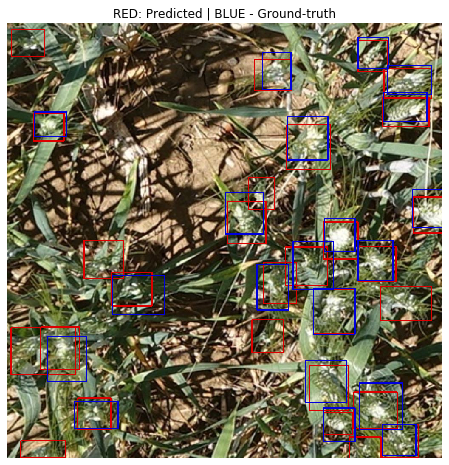

In [20]:
show_result(sample_id, preds, gt_boxes)

In [4]:
# Numba typed list!
import numba
iou_thresholds = numba.typed.List()

for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    iou_thresholds.append(x)

In [4]:
image_precision = calculate_image_precision(gt_boxes, preds_sorted,
                                            thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75],
                                            form='coco')

print("The average precision of the sample image: {0:.4f}".format(image_precision))

The average precision of the sample image: 0.3827
